In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  !nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


Tonality analysis for advanced jazz voiced phrases

1.   List item
2.   List item



In [2]:
# If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install mir_eval
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.6 MB 27.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 15.0 MB/s 
     |████████████████████████████████| 51 kB 65 kB/s 
     |████████████████████████████████| 5.6 MB 50.9 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=a56c50963a989e64e032ef078a444008954239b737c25f58664d4368368d7035
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64922 sha256=436d73d7be119e10808c88785ac137631c2400f2f71726c632a4cd63d5119e99
  Stored in directory: /root/.cache/pip/whee

In [5]:
#Basic imports
from __future__ import print_function
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Imports to support MIR
import mirdata
import mir_eval
import essentia.streaming as ess
import essentia
import pandas as pd

In [8]:
#audio_file = '/content/sample_data/Track No01.mp3'
audio_file = '/content/drive/MyDrive/Material musical/PARTITURES, SCORES, ARRANJAMENTS, COMPOSICIONS/TRANSCRIPCIONS/Peter Alqmvist/All The Things You Are (Peter Alqmvist - Solo).wav'

In [9]:
# Initialize algorithms we will use.
loader = ess.MonoLoader(filename=audio_file)
framecutter = ess.FrameCutter(frameSize=4096, hopSize=2048, silentFrames='noise')
windowing = ess.Windowing(type='blackmanharris62')
spectrum = ess.Spectrum()
spectralpeaks = ess.SpectralPeaks(orderBy='magnitude',
                                  magnitudeThreshold=0.00001,
                                  minFrequency=20,
                                  maxFrequency=3500,
                                  maxPeaks=60)

In [10]:
# Use default HPCP parameters for plots.
# However we will need higher resolution and custom parameters for better Key estimation.

hpcp = ess.HPCP()
hpcp_key = ess.HPCP(size=36, # We will need higher resolution for Key estimation.
                    referenceFrequency=440, # Assume tuning frequency is 44100.
                    bandPreset=False,
                    minFrequency=20,
                    maxFrequency=3500,
                    weightType='cosine',
                    nonLinear=False,
                    windowSize=1.)

In [11]:
key = ess.Key(profileType='diatonic', # Use profile for electronic music.
              numHarmonics=11,
              pcpSize=36,
              slope=0.6,
              usePolyphony=True,
              useThreeChords=True)

In [12]:
# Use pool to store data.
pool = essentia.Pool()

In [13]:
# Connect streaming algorithms.
loader.audio >> framecutter.signal
framecutter.frame >> windowing.frame >> spectrum.frame
spectrum.spectrum >> spectralpeaks.spectrum
spectralpeaks.magnitudes >> hpcp.magnitudes
spectralpeaks.frequencies >> hpcp.frequencies
spectralpeaks.magnitudes >> hpcp_key.magnitudes
spectralpeaks.frequencies >> hpcp_key.frequencies
hpcp_key.hpcp >> key.pcp
hpcp.hpcp >> (pool, 'tonal.hpcp')
key.key >> (pool, 'tonal.key_key')
key.scale >> (pool, 'tonal.key_scale')
key.strength >> (pool, 'tonal.key_strength')

In [14]:
# Run streaming network.
essentia.run(loader)

In [15]:
print("Estimated key and scale:", pool['tonal.key_key'] + " " + pool['tonal.key_scale'])

Estimated key and scale: Ab major


In [16]:
import IPython
IPython.display.Audio(audio_file)

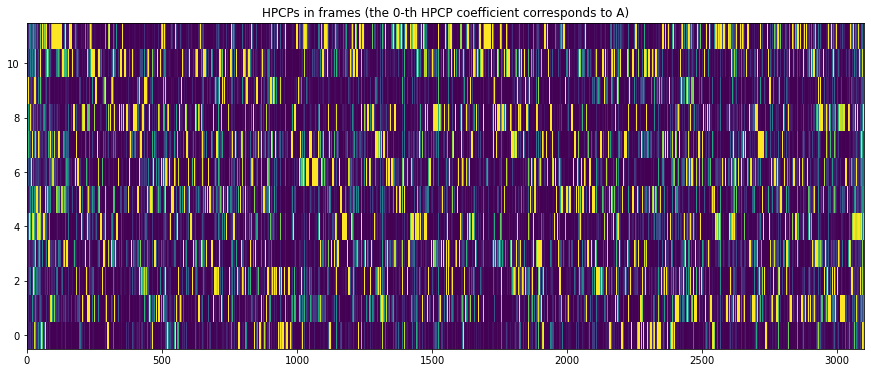

In [17]:
# Plots configuration.
import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow
plt.rcParams['figure.figsize'] = (15, 6)

# Plot HPCP.
imshow(pool['tonal.hpcp'].T, aspect='auto', origin='lower', interpolation='none')
plt.title("HPCPs in frames (the 0-th HPCP coefficient corresponds to A)")
show()

In [18]:
print("Estimated key and scale:", pool['tonal.key_key'] + " " + pool['tonal.key_scale'])

Estimated key and scale: Ab major
